# Import

In [1]:
# Misc
import os
import json
import joblib
import warnings
from ipywidgets import IntProgress
from IPython.display import display

# Data management
import numpy as np
import pandas as pd

# Sound treatments
import librosa
import soundfile as sf
from scipy import signal

# Data generator
from tensorflow.keras.utils import Sequence

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as pimnv2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as piv3
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import preprocess_input as penb0
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as prn50

# VGGish
from vggish import vggish_input
from vggish import vggish_params as params
import vggish_keras as vgk

# TRILL
import tensorflow.compat.v2 as tf2
tf2.enable_v2_behavior()
assert tf2.executing_eagerly()
import tensorflow_hub as hub

# Metrics
import tensorflow_addons as tfa
from tensorflow_addons.layers.netvlad import NetVLAD

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Environment

In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Disable SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Display Tensorlfow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.config.list_physical_devices('GPU'):
    print('No GPU found. Please ensure you have installed TensorFlow correctly')

else:
    print('Default GPU Device: {}'.format(
        tf.config.list_physical_devices('GPU')))

    # Allow memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow Version: 2.6.0
Default GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DATA_PATH = './data/'
WORKING_PATH = './working/final/'

# Data exploration

## Data load

In [4]:
# Load meta data
train_meta = pd.read_csv(DATA_PATH + 'train_metadata.csv',
                         sep=',', decimal='.', encoding='utf8', low_memory=False)

In [5]:
train_meta.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [6]:
# Load scored birds
with open(DATA_PATH + 'scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

scored_birds

['akiapo',
 'aniani',
 'apapan',
 'barpet',
 'crehon',
 'elepai',
 'ercfra',
 'hawama',
 'hawcre',
 'hawgoo',
 'hawhaw',
 'hawpet1',
 'houfin',
 'iiwi',
 'jabwar',
 'maupar',
 'omao',
 'puaioh',
 'skylar',
 'warwhe1',
 'yefcan']

## Distribution per class

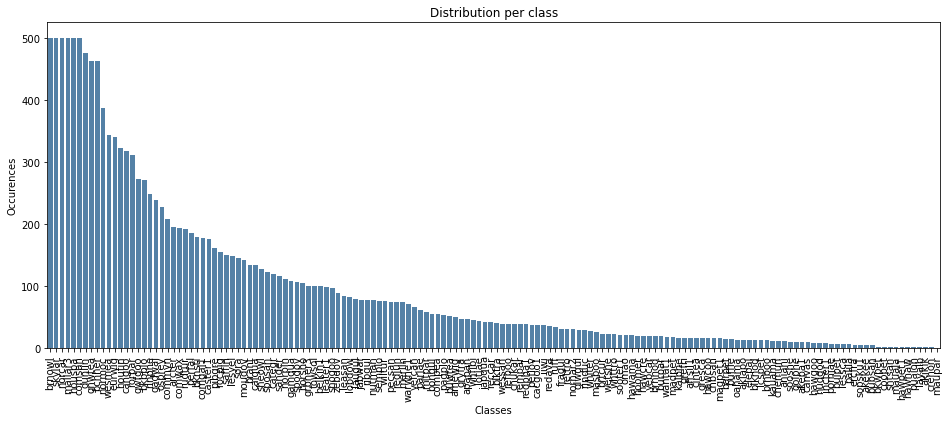

In [7]:
birds = train_meta["primary_label"].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds.keys()), y=list(birds.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [8]:
key_max = max(birds.keys(), key=(lambda k: birds[k]))
key_min = min(birds.keys(), key=(lambda k: birds[k]))

print('Number of classes: ', len(birds.keys()))
print('')
print('Minimum number of sounds for the class: ',
      key_min + ' ' + str(birds[key_min]))
print('Maximum number of sounds for the class: ',
      key_max + ' ' + str(birds[key_max]))
print('Total number of sounds: ', sum(birds.values()))
print('Average number of sounds per classes: ',
      sum(birds.values()) / len(birds.values()))

Number of classes:  152

Minimum number of sounds for the class:  maupar 1
Maximum number of sounds for the class:  brnowl 500
Total number of sounds:  14852
Average number of sounds per classes:  97.71052631578948


## Focus on scored birds

In [9]:
# Focus on 21 scored classes
data_filtered = train_meta[train_meta['primary_label'].isin(scored_birds)]

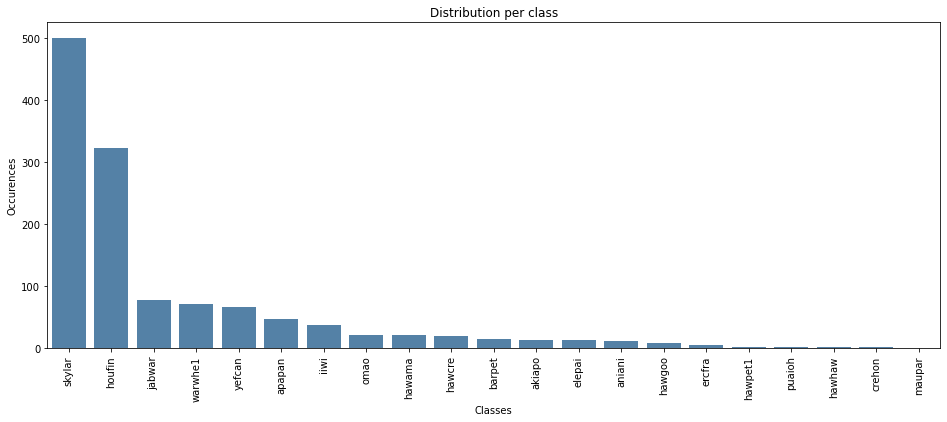

In [10]:
birds_filtered = data_filtered['primary_label'].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds_filtered.keys()), y=list(
    birds_filtered.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [11]:
key_max = max(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))
key_min = min(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))

print('Number of classes: ', len(birds_filtered.keys()))
print('Missing classes: ', scored_birds-birds_filtered.keys())
print('')
print('Minimum number of sounds for the class: ',
      key_min + ' ' + str(birds_filtered[key_min]))
print('Maximum number of sounds for the class: ',
      key_max + ' ' + str(birds_filtered[key_max]))
print('Total number of sounds: ', sum(birds_filtered.values()))
print('Average number of sounds per classes: ', sum(
    birds_filtered.values()) / len(birds_filtered.values()))

Number of classes:  21
Missing classes:  set()

Minimum number of sounds for the class:  maupar 1
Maximum number of sounds for the class:  skylar 500
Total number of sounds:  1266
Average number of sounds per classes:  60.285714285714285


## Birds number per sound

In [12]:
# Split secondary_labels in a list of birds
def split_secondary(df):
    record = df['secondary_labels'].replace(
        '[', '').replace(']', '').replace("'", "").split(',')
    return record


data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)

In [13]:
# Count the birds in the birds lists
def birds_number(df):
    return len(df['secondary_list'])


data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

In [14]:
data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)
data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

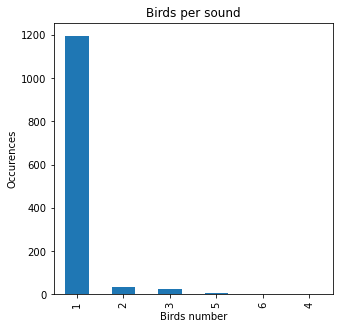

In [15]:
fig = plt.figure(figsize=(5, 5))
data_filtered['birds_number'].value_counts().plot(kind='bar')
plt.title('Birds per sound')
plt.xlabel('Birds number')
plt.ylabel('Occurences')
plt.show()

In [16]:
data_filtered['birds_number'].value_counts()

1    1197
2      35
3      23
5       5
6       3
4       3
Name: birds_number, dtype: int64

## Misc

In [17]:
data_filtered['primary_label'].value_counts()

skylar     500
houfin     322
jabwar      78
warwhe1     71
yefcan      67
apapan      47
iiwi        37
omao        21
hawama      21
hawcre      20
barpet      15
akiapo      14
elepai      14
aniani      12
hawgoo       9
ercfra       6
hawpet1      3
puaioh       3
hawhaw       3
crehon       2
maupar       1
Name: primary_label, dtype: int64

In [18]:
data_filtered.shape

(1266, 15)

## Sounds characteristics

In [19]:
if not os.path.exists(WORKING_PATH + 'sample_rates.jl'):
    # Instantiate the progress bar
    max_count = data_filtered.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    sample_rates = {}
    durations = []

    for index, row in data_filtered.iterrows():
        # Increment the progress bar
        f.value += 1

        # Load sound
        file_path = DATA_PATH + 'train_audio/' + row['filename']
        audio, sr = librosa.load(file_path)

        # Calculate duration
        duration = len(audio)/sr

        # Store
        if sr in sample_rates.keys():
            sample_rates[sr] += 1
        else:
            sample_rates[sr] = 1

        durations.append(duration)

    # Save
    joblib.dump(sample_rates, WORKING_PATH + 'sample_rates.jl')
    joblib.dump(durations, WORKING_PATH + 'durations.jl')

else:
    sample_rates = joblib.load(WORKING_PATH + 'sample_rates.jl')
    durations = joblib.load(WORKING_PATH + 'durations.jl')

In [20]:
print('Audios sample rates:', sample_rates)

Audios sample rates: {22050: 1266}


In [21]:
durations = np.array(durations)
print('Audios minimum duration:', np.min(durations))
print('Audios maximum duration:', np.max(durations))
print('Audios average duration:', np.mean(durations))

Audios minimum duration: 1.1160090702947847
Audios maximum duration: 996.9840362811791
Audios average duration: 53.04552557199815


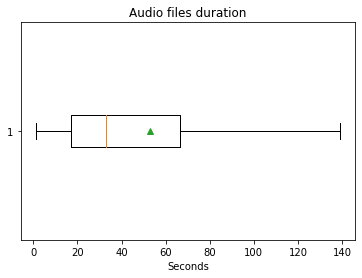

In [22]:
plt.boxplot(durations, vert=False, showmeans=True, showfliers=False)
plt.title('Audio files duration')
plt.xlabel('Seconds')
plt.show()

In [23]:
np.quantile(durations, 0.75, axis=0)

66.32963718820862

In [24]:
np.mean(durations)

53.04552557199815

## Conclusion

- 1266 audio files available for 21 classes
- Imbalanced data
- Most of the time, a sound contains 1 classe but sometimes more (multilabel)
- Sample rate 22050
- Sounds average duration is 50.42 seconds

# Baseline

- My baseline comes from the Kaggle kernel

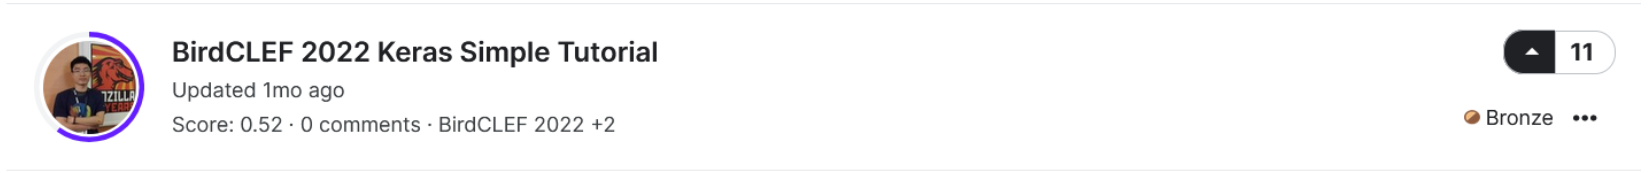

https://www.kaggle.com/code/duythanhng/birdclef-2022-keras-simple-tutorial

- It implements MFCC features extraction + MobileNetV2 for a multiclass classification 
- It has been trained with the 152 classes available
- It obtained a Kaggle submission score of 0.52

##### Modifications

- Adapt script to PEP8 standard
- Correction of cutAudio function for the last chunk to have the same lenght than others
- Load extracted features to RAM to speed up the training process
- Change learning rate strategy (Monitor val_loss instead of val_f1macro, ReduceLROnPlateau: factor=0.9)
- Focus only on 21 scored classes for training
- Switch to multi label classification (activation: softmax to sigmoid, loss: categorical_crossentropy to binary_crossentropy)
- Data normalization using MobileNetV2 preprocess_input functions
- Set up from 1 to 3 channels

## Split or load

In [25]:
def cutAudio(seconds, file_path, is_save):
    # First load the file
    filename = file_path.replace('/', '_')
    file_path = DATA_PATH + 'train_audio/' + file_path
    audio, sr = librosa.load(file_path)

    # Get number of samples for x seconds
    buffer = seconds * sr
    block_min = seconds * sr

    samples_total = len(audio)
    samples_wrote = 0
    counter = 1

    audio_split = []
    audio_filenames = []

    while samples_wrote < samples_total:
        # check if the buffer is not exceeding total samples
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote

        block = audio[samples_wrote: (samples_wrote + buffer)]

        # check if last block is as long as previous ones
        if block.shape[0] < (block_min):
            listofzeros = np.array([0] * (block_min - block.shape[0]))
            block = np.hstack([block, listofzeros])

        audio_split.append(block)

        # Write segment
        if is_save == True:
            out_filename = WORKING_PATH + 'each' + str(seconds) + 's/split_' + \
                str(counter) + '_' + filename
            audio_filenames.append(out_filename)
            sf.write(out_filename, block, sr)

        counter += 1
        samples_wrote += buffer

    return audio_split, sr, audio_filenames

In [26]:
def splitTrainAudio(seconds, _df):
    # Instantiate the progress bar
    max_count = _df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    data = []
    for index, row in _df.iterrows():
        # Increment the progress bar
        f.value += 1

        audio_lst, sr, filenames = cutAudio(seconds, row['filename'], True)

        for idx, y in enumerate(audio_lst):
            data.append(
                [row['primary_label'], row['secondary_labels'], row['filename'], filenames[idx]])

    data_df = pd.DataFrame(
        data, columns=['primary_label', 'secondary_labels', 'original_filename', 'filename'])
    data_df.to_csv(WORKING_PATH + 'data_' +
                   str(seconds) + '_df.csv', index=False)

In [27]:
if len(os.listdir(WORKING_PATH + 'each5s/')) == 0:
    # If not already done, split audio into 5 seconds chunks

    # Split audio
    splitTrainAudio(5, data_filtered)

    # Load split result
    data_df = pd.read_csv(WORKING_PATH + 'data_5_df.csv')

else:
    # If split done, load split result
    data_df = pd.read_csv(WORKING_PATH + 'data_5_df.csv')

## Create target

In [28]:
def to_list(df):
    temp = []
    primary_label = df['primary_label']

    if df['secondary_labels'] != '[]':
        secondary_labels = df['secondary_labels'].replace(
            '[', '').replace(']', '').replace("'", '').replace(' ', '').split(',')
    else:
        secondary_labels = None

    temp.append(primary_label)

    if secondary_labels != None:
        for item in secondary_labels:
            if item in scored_birds:
                if item not in temp:
                    temp.append(item)

    return tuple(temp)

In [29]:
# Create target
data_df['target'] = data_df.apply(to_list, axis=1)
data_df.to_pickle(WORKING_PATH + 'data.pkl')
data_df = pd.read_pickle(WORKING_PATH + 'data.pkl')
data_df

,primary_label,secondary_labels,original_filename,filename,target
0,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_1_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
1,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_2_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
2,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_3_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
3,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_4_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
4,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_5_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
...,...,...,...,...,...
14075,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_3_yefcan_XC667142...,"(yefcan,)"
14076,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_4_yefcan_XC667142...,"(yefcan,)"
14077,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_5_yefcan_XC667142...,"(yefcan,)"
14078,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_6_yefcan_XC667142...,"(yefcan,)"


## MultiLabelBinarizer

In [30]:
# Fit a MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(data_df['target'].values.tolist())
mlb.classes_

array(['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai',
       'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1',
       'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar',
       'warwhe1', 'yefcan'], dtype=object)

## Data generator

In [31]:
class DataGenerator(Sequence):
    def __init__(self,
                 _X,
                 batch_size=32,
                 n_channels=1,
                 n_columns=470,
                 n_rows=120,
                 shuffle=True):
        self.batch_size = batch_size
        self.X = _X
        self.n_channels = n_channels
        self.n_columns = n_columns
        self.n_rows = n_rows
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, self.n_rows,
                     self.n_columns, self.n_channels))
        y = np.empty((self.batch_size, len(mlb.classes_)), dtype=int)
        for i, ID in enumerate(list_IDs_temps):
            file_path = self.X.iloc[ID]['filename']

            #audio, sr = librosa.load(file_path)
            #feat = extractFeatures(audio, sr)

            feat = data_mem[file_path]

            #x_features = feat.tolist()
            #X[i] = np.array(x_features)
            X[i] = feat

            label = self.X.iloc[ID]['target']
            y[i] = mlb.transform([label])

        return X, y

In [32]:
data_mem = {}


def LoadRAM():
    # Load extracted features into RAM
    data_mem.clear()

    # Instantiate the progress bar
    max_count = data_df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    temp = {}

    for index, row in data_df.iterrows():
        # Increment the progress bar
        f.value += 1

        # Get file path
        file_path = row['filename']
        # Load audio file
        audio, sr = librosa.load(file_path)
        # Extracxt features
        feat = extractFeatures(audio, sr)

        # Store features into the dedicated dictionary
        temp[row['filename']] = feat

    return temp

## Preprocessing

In [33]:
def extractFeatures(y, sr):
    # Extract mfcc
    feat = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=conf.num_rows, n_mels=conf.n_mels)
    # Feed columns with 0 if number of columns < conf.num_columns
    if feat.shape[1] <= conf.num_columns:
        pad_width = conf.num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=(
            (0, 0), (0, pad_width)), mode='constant')
    # 3 channels
    feat = np.stack([feat, feat, feat], axis=-1)
    # preprocess
    feat = pimnv2(feat)

    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    x_features = feat.tolist()
    X[0] = np.array(x_features)

    return X

## Model

In [34]:
def create_cnn(model_name,
               fine_tune_at=None,
               model_path=None
               ):

    # Instanciate model
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(include_top=False, input_shape=(
            conf.num_rows, conf.num_columns, conf.num_channels), weights='imagenet', pooling='avg')

    outputs = Dense(len(mlb.classes_), activation='sigmoid')(base_model.output)

    base_model.trainable = False

    model = Model(inputs=base_model.input, outputs=outputs)

    if fine_tune_at != None:
        # Load existing weights
        model.load_weights(model_path)

        # Unfreeze model layers
        model.trainable = True

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False

    return model

## Training

In [35]:
def plot_his(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['f1macro'])
    plt.plot(history.history['val_f1macro'])
    plt.title('model f1macro')
    plt.ylabel('f1macro')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()

In [36]:
class conf:
    # Preprocessing settings
    n_mels = 224

    # Model parameters
    num_rows = 224
    num_columns = 224
    num_channels = 3

In [37]:
params = dict(
    batch_size=32,
    n_rows=conf.num_rows,
    n_columns=conf.num_columns,
    n_channels=conf.num_channels,
)
params_train = dict(
    shuffle=True,
    **params
)
params_valid = dict(
    shuffle=False,
    **params
)

In [38]:
def train_model(session_prefix,
                model_name,
                train_gen,
                val_gen,
                test_gen,
                fine_tune_at,
                model_path,
                learning_rate,
                epochs):

    # Define checkpoint_model_path
    checkpoint_model_path = WORKING_PATH + session_prefix + model_name + '.h5'

    num_epochs = epochs
    metric = 'val_loss'

    # Callbacks
    checkpointer = ModelCheckpoint(filepath=checkpoint_model_path,
                                   monitor=metric,
                                   mode='min',
                                   verbose=1,
                                   save_best_only=True)

    es_callback = EarlyStopping(monitor=metric,
                                mode='min',
                                patience=5,
                                verbose=1,
                                restore_best_weights=True
                                )

    reduce_lr = ReduceLROnPlateau(monitor=metric,
                                  factor=0.9,
                                  mode='min',
                                  patience=1,
                                  verbose=1,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=0.00001)

    # Model
    model = create_cnn(model_name, fine_tune_at, model_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(mlb.classes_), average='macro')])

    # Fit
    history = model.fit(
        train_gen,
        epochs=num_epochs,
        validation_data=val_gen,
        callbacks=[checkpointer, es_callback, reduce_lr],
        verbose=1
    )

    # Graph
    plot_his(history)

    # Scoring
    evaluation = model.evaluate_generator(test_gen)
    print('Scoring on test set:', evaluation)

In [37]:
# Load data in RAM to speed up training process
data_mem = LoadRAM()

IntProgress(value=0, max=14080)

In [39]:
# Split data
X_train, X_test, _, _ = train_test_split(
    data_df, data_df['target'], test_size=0.1, random_state=42)
X_train, X_valid, _, _ = train_test_split(
    X_train, X_train['target'], test_size=0.2, random_state=42)

# Instanciate data generators
train_generator = DataGenerator(X_train, **params_train)
valid_generator = DataGenerator(X_valid, **params_valid)
test_generator = DataGenerator(X_test, **params_valid)

Epoch 1/50
316/316 [==============================] - 16s 36ms/step - loss: 0.1605 - f1macro: 0.0629 - val_loss: 0.1442 - val_f1macro: 0.0740

Epoch 00001: val_loss improved from inf to 0.14422, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 34ms/step - loss: 0.1357 - f1macro: 0.1014 - val_loss: 0.1331 - val_f1macro: 0.1222

Epoch 00002: val_loss improved from 0.14422 to 0.13308, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [==============================] - 11s 34ms/step - loss: 0.1272 - f1macro: 0.1325 - val_loss: 0.1253 - val_f1macro: 0.1378

Epoch 00003: val_loss improved from 0.13308 to 0.12534, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 4/50
316/316 [==============================] - 11s 34ms/step - loss: 0.1218 - f1macro: 0.1492 - val_loss: 0.1222 - val_f1macro: 0.1688

Epoch 00004: val_loss improved from 0.12534 to 0.12222, saving model to ./working/final\baseline

316/316 [==============================] - 11s 34ms/step - loss: 0.0917 - f1macro: 0.4779 - val_loss: 0.1035 - val_f1macro: 0.3161

Epoch 00032: val_loss improved from 0.10348 to 0.10347, saving model to ./working/final\baseline_MobileNetV2.h5

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
Epoch 33/50
316/316 [==============================] - 11s 34ms/step - loss: 0.0914 - f1macro: 0.4799 - val_loss: 0.1033 - val_f1macro: 0.3399

Epoch 00033: val_loss improved from 0.10347 to 0.10326, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 34/50
316/316 [==============================] - 11s 34ms/step - loss: 0.0912 - f1macro: 0.4831 - val_loss: 0.1036 - val_f1macro: 0.3186

Epoch 00034: val_loss did not improve from 0.10326

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 35/50
316/316 [==============================] - 11s 34ms/step - loss: 0.0909 - f1macro: 0.4890 - val_loss: 0.1031 - val_f1macro: 0.3342

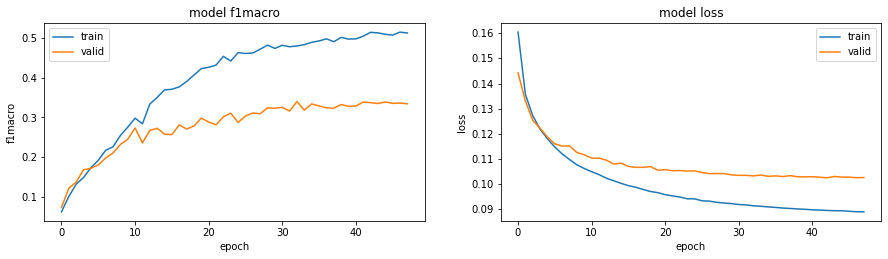

Scoring on test set: [0.10393772274255753, 0.3079107701778412]


In [39]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50)

## Conclusion

- Score on test set
    - F1 macro: 0.3079
    - Loss: 0.1039